In [1]:
import gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)



In [2]:
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))
        std = F.softplus(self.fc_std(x))
        return mu, std


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)
        self.gamma = gamma
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, sigma = self.actor(state)
        action_dist = torch.distributions.Normal(mu, sigma)
        action = action_dist.sample()
        return [action.item()]

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions)

        for _ in range(self.epochs):
            mu, std = self.actor(states)
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage
            actor_loss = torch.mean(-torch.min(surr1, surr2))
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()
            actor_loss.backward()
            critic_loss.backward()
            self.actor_optimizer.step()
            self.critic_optimizer.step()

In [3]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
import env_test
env = env_test.DroneEnv()
torch.manual_seed(0)


env.seed(0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
print(action_dim)

agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)
return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)


1


Iteration 0:   0%|          | 0/200 [00:00<?, ?it/s]C:\Users\10749\AppData\Local\Temp\ipykernel_23176\1068240052.py:33: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:264.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|██████████| 200/200 [00:59<00:00,  3.38it/s, episode=2000, return=-37186.772]


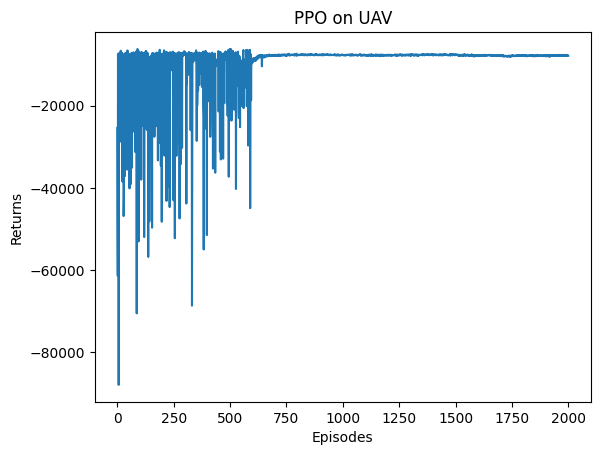

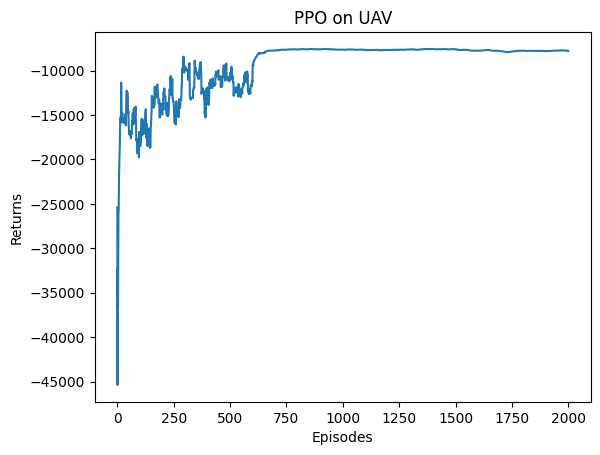

In [6]:

episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on UAV')
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title("PPO on UAV")
plt.show()

0.0
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.92508155] [-1.9543272256851196] -24.72271677546678
[0.         0.         0.         0.         0.         0.
 0.         0.         0.57281417] [-1.583036184310913] -17.240214086155675
[0.         0.         0.         0.         0.         0.
 0.         0.         0.41811982] [-0.49156904220581055] -12.42893925308067
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.23009908] [-2.0326154232025146] -7.488298428605049
[ 0.          0.          0.          0.          0.          0.
  0.          0.         -0.84565085] [-1.931106686592102] -23.840898658236938
[0.        0.        0.        0.        0.        0.        0.
 0.        0.6369158] [-1.630815029144287] -19.14606233014024
[0.        0.        0.        0.        0.        0.        0.
 0.        0.2369905] [-1.2603071928024292] -7.632688919115253
[ 0.          0.          0.          0.

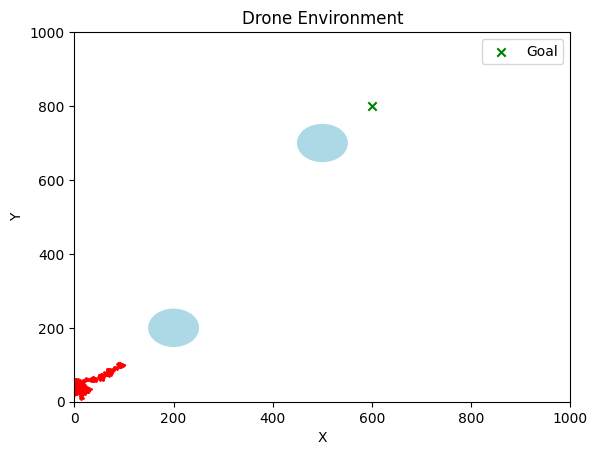

-7765.457810180285
501


In [7]:

# 创建一张图
plt.figure()

# 绘制障碍物
for k in env.obstacles:
    obstacle_circle = plt.Circle(k, env.r_obstacles, color='lightblue', fill=True)
    plt.gca().add_patch(obstacle_circle)

plt.scatter(env.goal[0], env.goal[1], marker='x', color='green', label='Goal')
plt.xlim(env.space1.low[0], env.space1.high[0])
plt.ylim(env.space1.low[1], env.space1.high[1])
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Drone Environment')
#plt.show()
state = env.reset()
print(state[0])
env.render(mode='human')

done = False
r = 0
count = 0
while not done:
    count += 1
    env.render(mode='human')
    action = agent.take_action(state)
    #action[0] = 0.03
    next_state, reward, done, info = env.step(action)
    print(state, action, reward)
    if count > 500:
        done = True
    r += reward
    state = next_state
    #print(state)
plt.show()
print(r)
print(count)